In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
from linear_mcmc import *

from redTools import *
from Kcorrect import *
from calibTools import *

In [2]:
calib_maglim = [3974, 6699, 9962, 11139, 12460, 13163, 19871, 
                21102, 22277, 26761, 28378, 29128, 38148, 41020, 
                41093, 44982, 45084, 46127, 49448, 50073, 53641, 67908, 72228]
I_maglim = [38803, 39181, 39431, 39619, 40005, 40107, 40147, 40588,
            40604, 41567, 41829, 42768, 5807403, 5057729, 4002181, 4321374, 37814]

In [3]:
table   = np.genfromtxt('corrected_mags_linewidth_all.csv' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)

In [4]:
band = 'i'
Clusters, slope0, zp0, slope_e0 = TF_iter(table, band = band, n_iter=10, verbose=False)
print slope0, zp0

zp_calibs = all_ZP(table, band=band, slope=slope0, pgcFaint=calib_maglim)
slope = zp_calibs['slope']
zp    = zp_calibs['zp']
print slope0, slope_e0, slope, zp

-8.350515412546955 6.760742748753189e-09
108
-8.350515412546955 0.13021637583046314 -8.350515412546955 -20.850316178374477


In [5]:
Clusters = allCluster(table, band=band, slope=slope)
key0 = 'NEST_100002'
myCluster = Clusters[key0]
zp_virgo = myCluster['zp']
I_mag = myCluster['mag']-zp_virgo+zp
logWimx = myCluster['logWimx']
pgc_ = myCluster['pgc']
for i, key in enumerate(Clusters):
    if key!=key0:
        myCluster = Clusters[key]
        zp_ = myCluster['zp']
        I_mag = np.concatenate((I_mag, myCluster['mag']-zp_+zp))
        logWimx = np.concatenate((logWimx, myCluster['logWimx']))
        pgc_ =  np.concatenate((pgc_, myCluster['pgc']))
        
        
indx, = np.where(I_mag>-17)
pgcFaint = pgc_[indx]

print pgcFaint

[  38803.   39181.   39431.   39619.   40005.   40107.   40588.   40604.
   41567.   41829.   42768. 5807403. 5057729.   37814.]


In [6]:
band = 'i'
Clusters, slope0, zp0, slope_e0 = TF_iter(table, band = band, n_iter=10, verbose=False, pgcFaint=pgcFaint)
print slope0, zp0

zp_calibs = all_ZP(table, band=band, slope=slope0, pgcFaint=calib_maglim)
slope = zp_calibs['slope']
zp    = zp_calibs['zp']
zp_e = zp_calibs['zp_e']
print slope0, slope_e0, slope, zp

-8.36302194475208 0.0018002728259330337
108
-8.36302194475208 0.1328393438730163 -8.36302194475208 -20.850610540966926


In [7]:
Clusters = allCluster(table, band=band, slope=slope, pgcFaint=pgcFaint)
key0 = 'NEST_100002'
myCluster = Clusters[key0]
zp_virgo = myCluster['zp']
I_mag = myCluster['mag']-zp_virgo+zp
logWimx = myCluster['logWimx']
pgc_ = myCluster['pgc']
for i, key in enumerate(Clusters):
    if key!=key0:
        myCluster = Clusters[key]
        zp_ = myCluster['zp']
        I_mag = np.concatenate((I_mag, myCluster['mag']-zp_+zp))
        logWimx = np.concatenate((logWimx, myCluster['logWimx']))
        pgc_ =  np.concatenate((pgc_, myCluster['pgc']))
        
        
indx, = np.where(I_mag>-17)
pgcFaint = pgc_[indx]

print pgcFaint

[  38803.   39181.   39431.   39619.   40005.   40107.   40147.   40588.
   40604.   41567.   41829.   42768. 5807403. 5057729.   37814.]


457
457
15
[  38803.   39181.   39431.   39619.   40005.   40107.   40147.   40588.
   40604.   41567.   41829.   42768. 5807403. 5057729.   37814.]
[3974, 6699, 9962, 11139, 12460, 13163, 19871, 21102, 22277, 26761, 28378, 29128, 38148, 41020, 41093, 44982, 45084, 46127, 49448, 50073, 53641, 67908, 72228]


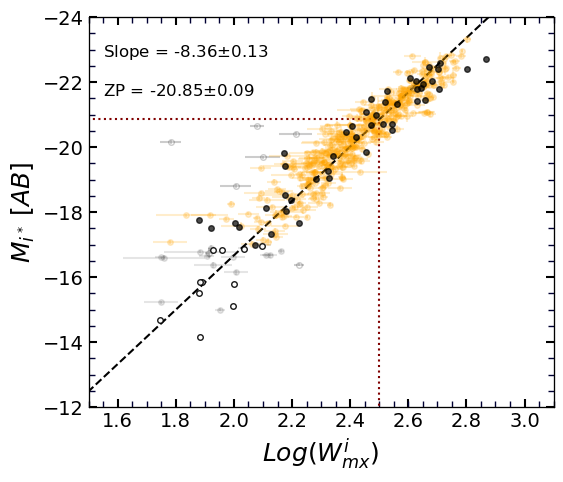

In [8]:
Clusters = allCluster(table, band=band, slope=slope, pgcFaint=pgcFaint)

dye = {"u":"blue","g":"green","r":"red","i":"orange","z":"maroon","w1":"purple", 'w2': "brown"}
cmap = get_cmap(21)
fig, ax = makeFig(band=band, xLim = (1.5,3.1), yLim = (-12,-24), MAGabs=True)

key0 = 'NEST_100002'
myCluster = Clusters[key0]
zp_virgo = myCluster['zp']
I_mag = myCluster['mag']-zp_virgo+zp
logWimx = myCluster['logWimx']
pgc_ = myCluster['pgc']

for i, key in enumerate(Clusters):
    if key!=key0:
        myCluster = Clusters[key]
        zp_ = myCluster['zp']
        plotCluster(ax, Clusters, nest=key, offset=zp_-zp, plotErrors=True, 
                    alpha=0.2, markersize=0, pgcFaint=pgcFaint, plotWeird=True) # cmap(i)
        I_mag = np.concatenate((I_mag, myCluster['mag']-zp_+zp))
        logWimx = np.concatenate((logWimx, myCluster['logWimx']))
        pgc_ =  np.concatenate((pgc_, myCluster['pgc']))
    else:
        plotCluster(ax, Clusters, nest=key, offset=zp_virgo-zp, plotErrors=True, alpha=0.2, 
                    markersize=0, pgcFaint=pgcFaint, plotWeird=True)

plotCluster(ax, zp_calibs, markersize=8, plotFit=True, color='k', pgcFaint=calib_maglim)


Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.97*Xlm[0]+0.03*Xlm[1]
y0 = 0.1*Ylm[0]+0.90*Ylm[1]
ax.text(x0,y0, "Slope = "+"%.2f" % slope0+'$\pm$'+"%.2f" % slope_e0, fontsize=12, color='k')
y0 = 0.2*Ylm[0]+0.80*Ylm[1]
ax.text(x0,y0, "ZP = "+"%.2f" % zp+'$\pm$'+"%.2f" % zp_e, fontsize=12, color='k')



indx, = np.where(I_mag>-17)
print len(I_mag)
print len(pgc_)
print len(indx)

print pgc_[indx]
# ax.plot(logWimx[indx], I_mag[indx], 'ro')
print calib_maglim

In [9]:
####################################### Set Axes
def set_axes(ax_list, xlim, ylim):
    for ax in ax_list:
        
        ax.set_ylim(ylim)
        ax.set_xlim(xlim) 
        ax.tick_params(which='major', length=6, width=1.5, direction='in')
        ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')  

        y_ax = ax.twinx()
        y_ax.set_ylim(ylim)
        y_ax.set_yticklabels([])
        y_ax.minorticks_on()
        y_ax.tick_params(which='major', length=6, width=1.5, direction='in')
        y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')        

        x_ax = ax.twiny()
        x_ax.set_xlim(xlim)
        x_ax.set_xticklabels([])
        x_ax.minorticks_on()
        x_ax.tick_params(which='major', length=6, width=1.0, direction='in')
        x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(14) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(14) 
####################################### Plotting Function

u 40105
z 42089
0.5300000000000011


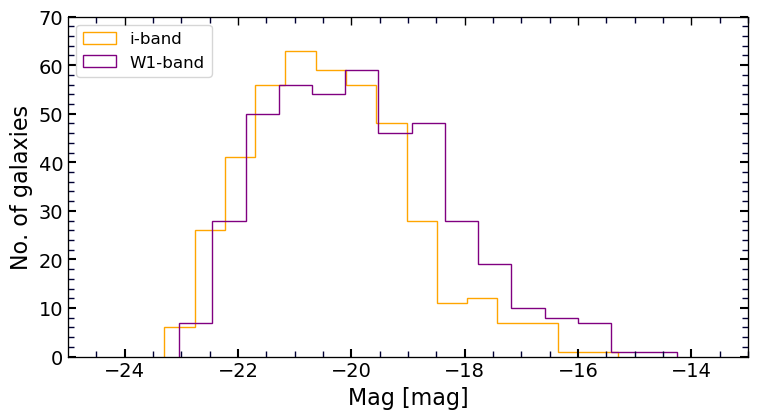

In [10]:
Clusters = allCluster(table, band='i')
key0 = 'NEST_100002'
myCluster = Clusters[key0]
zp_virgo = myCluster['zp']
Dmag = myCluster['mag']*0.-zp_virgo+zp
logWimx = myCluster['logWimx']
pgc_ = myCluster['pgc']
for i, key in enumerate(Clusters):
    if key!=key0:
        myCluster = Clusters[key]
        zp_ = myCluster['zp']
        Dmag = np.concatenate((Dmag, myCluster['mag']*0.-zp_+zp))
        logWimx = np.concatenate((logWimx, myCluster['logWimx']))
        pgc_ =  np.concatenate((pgc_, myCluster['pgc']))
        
        
pgc   = table['pgc']
mag_u = table['u_sss']
mag_g = table['g_sss']
mag_r = table['r_sss']
mag_i = table['i_sss']
mag_z = table['z_sss']
mag_w1= table['w1_sss']
mag_w2= table['w2_sss']
Sqlt = table['Sqlt']
Wqlt = table['Wqlt']

u_mag = []
g_mag = []
r_mag = []
i_mag = []
z_mag = []
w1_mag = []
w2_mag = []

for i, qlt in enumerate(Sqlt):
    if qlt >=2 and pgc[i] in pgc_ and Wqlt[i]>=2:
        indx, = np.where(pgc_==pgc[i])
        
        u_mag.append(Dmag[indx][0]+mag_u[i])
        g_mag.append(Dmag[indx][0]+mag_g[i])
        r_mag.append(Dmag[indx][0]+mag_r[i])
        i_mag.append(Dmag[indx][0]+mag_i[i])
        z_mag.append(Dmag[indx][0]+mag_z[i])
        w1_mag.append(Dmag[indx][0]+mag_w1[i])
        w2_mag.append(Dmag[indx][0]+mag_w2[i])
        
        if Dmag[indx][0]+mag_u[i] < -25 : print 'u', pgc[i]
        if Dmag[indx][0]+mag_g[i] < -25 : print 'g', pgc[i]
        if Dmag[indx][0]+mag_r[i] < -25 : print 'r', pgc[i]
        if Dmag[indx][0]+mag_i[i] < -25 : print 'i', pgc[i]        
        if Dmag[indx][0]+mag_z[i] < -25 : print 'z', pgc[i]
        if Dmag[indx][0]+mag_w1[i] < -25 : print 'w1', pgc[i]
        if Dmag[indx][0]+mag_w2[i] < -25 : print 'w2', pgc[i]
        
        
fig = plt.figure(figsize=(8, 4), dpi=100)
ax = fig.add_axes([0.13, 0.1, 0.85,  0.85])

# ax.hist(u_mag, bins=15, histtype='step', label='all sample', color='blue')
# ax.hist(g_mag, bins=15, histtype='step', label='all sample', color='green')
ax.hist(i_mag, bins=15, histtype='step', label='i-band', color='orange')
# ax.hist(r_mag, bins=15, histtype='step', label='all sample', color='red')
# ax.hist(z_mag, bins=15, histtype='step', label='all sample', color='maroon')

ax.hist(w1_mag, bins=15, histtype='step', label='W1-band', color='purple')
# ax.hist(w2_mag, bins=15, histtype='step', label='all sample', color='brown')

ax.set_xlabel('Mag [mag]', fontsize=16)
ax.set_ylabel('No. of galaxies', fontsize=16)

# ax.set_xlim([-25,-13])
set_axes([ax], [-25,-13], [0,70])

ax.legend(prop={'size': 12}, loc=2)

mag0 = np.asarray(i_mag)
mag1 = np.asarray(w1_mag)
a =  [] 
for i, magg in enumerate(i_mag):
    if magg > -24 and mag1[i] > -24 and magg<-17:
        a.append(mag1-mag0)
print np.median(a)

In [11]:
ctl   = np.genfromtxt('zp_photom_reduced.csv' , delimiter='|', filling_values=-1, 
                      names=True, dtype=None, encoding=None)
PGC  = ctl['PGC']
ID   = ctl['Name']
dist = ctl['d']

calib_maglim = []
for i, idd in enumerate(pgc):
    if idd in PGC:
        indx, = np.where(PGC==idd)
        if Sqlt[i]>=2:
            I = mag_i[i] - 5*np.log10(dist[indx][0]) - 25.
            if I>-17: 
                calib_maglim.append(idd)
#                 print i, 'I', idd
        elif Wqlt[i]>=2:
            W1 = mag_w1[i] - 5*np.log10(dist[indx][0]) - 25.
            if W1>-16.47: 
                calib_maglim.append(idd)
#                 print i, 'W1', idd            

print calib_maglim

[3974, 6699, 9962, 11139, 12460, 13163, 19871, 21102, 22277, 26761, 28378, 29128, 38148, 41020, 41093, 44982, 45084, 46127, 49448, 50073, 53641, 67908, 72228]
